In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [29]:
iris = load_iris()

# Convert dataset to Dataframe
df = pd.DataFrame(data= np.c_[iris['data'], iris['target']],
                    columns= iris['feature_names'] + ['target'])
df

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.1,3.5,1.4,0.2,0.0
1,4.9,3.0,1.4,0.2,0.0
2,4.7,3.2,1.3,0.2,0.0
3,4.6,3.1,1.5,0.2,0.0
4,5.0,3.6,1.4,0.2,0.0
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,2.0
146,6.3,2.5,5.0,1.9,2.0
147,6.5,3.0,5.2,2.0,2.0
148,6.2,3.4,5.4,2.3,2.0


In [30]:
# We can see that non NaN values are in the dataset
df.isna().sum()

sepal length (cm)    0
sepal width (cm)     0
petal length (cm)    0
petal width (cm)     0
target               0
dtype: int64

In [31]:
y = df[['target']].astype(int)  # convert target values to int-type
X = df.drop(y, axis=1)

In [32]:
# split training and test samples
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# for classification, scaling only performed on the X sample (never on the class_label/target y)
scaler = StandardScaler()

X_train_std = scaler.fit_transform(X_train)   # fit and transform on X_training
X_test_std  = scaler.transform(X_test)        # only transform on X_test

In [33]:
# covariance matriz
cov_mat = np.cov(X_train_std.T)
cov_mat

array([[ 1.00840336, -0.10782479,  0.86942015,  0.8082152 ],
       [-0.10782479,  1.00840336, -0.43571959, -0.3726137 ],
       [ 0.86942015, -0.43571959,  1.00840336,  0.97066591],
       [ 0.8082152 , -0.3726137 ,  0.97066591,  1.00840336]])

In [34]:
# calculating eigenvalues and eigenvectors
eigen_vals, eigen_vecs = np.linalg.eig(cov_mat)
eigen_vals

array([2.92644395, 0.92776828, 0.15976229, 0.01963892])

In [55]:
sum_eigen_vals = sum(eigen_vals)
explained_variance_ratio = [i/sum_eigen_vals for i in sorted(eigen_vals, reverse=True)]

# we can observe that the two more contributing Principal Components contains around the 95% of variance/information.
explained_variance_ratio

[0.7255142299182121,
 0.2300092184443889,
 0.03960773501619384,
 0.0048688166212052285]

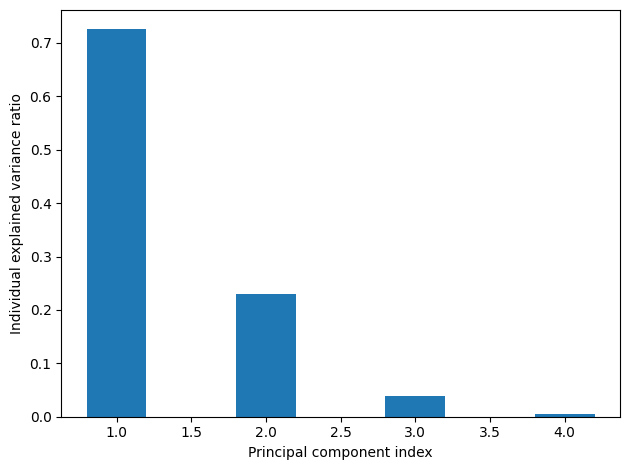

In [36]:
plt.bar(range(1, 5), explained_variance_ratio, align='center', width=0.4)
plt.ylabel("Individual explained variance ratio")
plt.xlabel("Principal component index")
plt.tight_layout()
plt.show()

In [37]:
# For this example, we keep the two principal components when applying PCA
# PCA trasformation is only performed on the training sample

pca = PCA(n_components=2)

X_train_pca = pca.fit_transform(X_train_std)  # fit and transform on the training X
X_test_pca  = pca.transform(X_test_std)       # only transform on the test X

X_train_pca = pd.DataFrame(X_train_pca, columns=['PCA_1', 'PCA_2'])
X_test_pca  = pd.DataFrame(X_test_pca,  columns=['PCA_1', 'PCA_2'])

In [39]:
# The fit is performed only for training sample
classifier = LogisticRegression(max_iter=1000, n_jobs=-1).fit(X_train_pca, y_train.values.ravel())

In [40]:
from sklearn.inspection import DecisionBoundaryDisplay

def ContourPlot(estimator, X_train, y_train, X_test, y_test, labels):

    colors=['purple', 'teal', 'gold']

    # creating boundaries (contours) using the train sample
    disp = DecisionBoundaryDisplay.from_estimator(estimator, X_train, response_method="auto",
                                                  grid_resolution=1000, plot_method='pcolormesh',
                                                  xlabel=labels[0], ylabel=labels[1],
                                                  alpha=0.45, cmap='viridis',
                                                  )
    # points for training dataset
    for class_label, color in zip(np.unique(y_train), colors):
        mask = y_train == class_label

        plt.scatter(X_train.iloc[:, 0:1][mask], X_train.iloc[:, 1:][mask],
                    label=f"Class {class_label}", edgecolor="k", color=color)

    # points for test dataset
    for class_label, color in zip(np.unique(y_test), colors):
        mask = y_test == class_label

        plt.scatter(X_test.iloc[:, 0:1][mask], X_test.iloc[:, 1:][mask],
                    marker='*', s=80, edgecolor="k", color=color)

    plt.legend()
    plt.show()

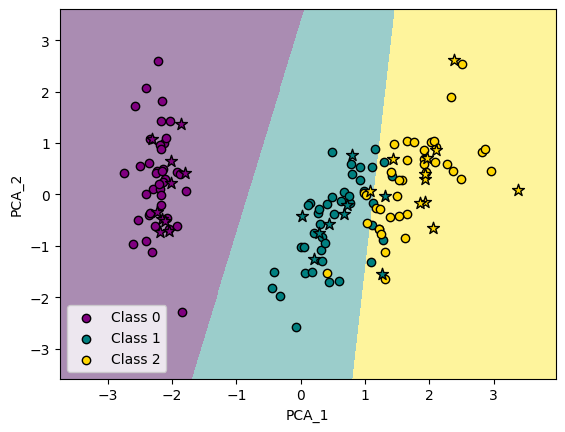

In [41]:
ContourPlot(estimator=classifier,
            X_train=X_train_pca, y_train=y_train.values.ravel(),
            X_test=X_test_pca,   y_test=y_test.values.ravel(),
            labels=('PCA_1', 'PCA_2'))

# balls represents training dataset
# stars represents test dataset

In [42]:
# correlation between the original features and the principal component
sklearn_loadings = pca.components_.T * np.sqrt(pca.explained_variance_)

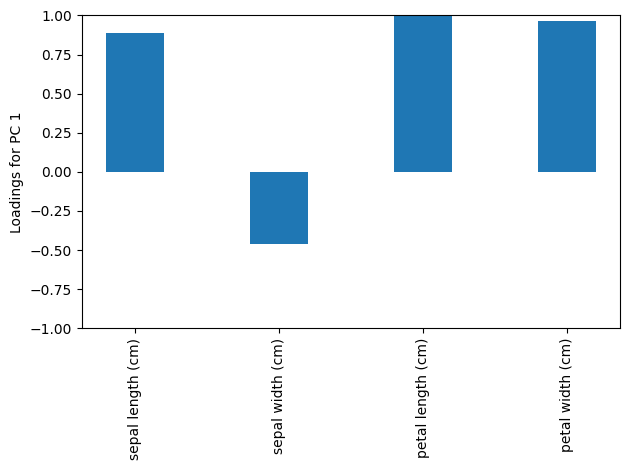

In [43]:
fig, ax = plt.subplots()
ax.bar(range(4), sklearn_loadings[:, 0], align='center', width=0.4)  # component 0 : PCA_1 # component 1: PCA_2
ax.set_ylabel('Loadings for PC 1')
ax.set_xticks(range(4))
ax.set_xticklabels(X.columns, rotation=90)
plt.ylim([-1, 1])
plt.tight_layout()
plt.show()

In [44]:
# As comment, for classification (supervised technique) is better LDA than PCA.
# LDA (supervised) focus create linear combinations of the original features (new variables) such that these maximize the class separation.
# PCA (unsupervised) only focus on dimensionality reduction maximizing the variance (keeping most information).

In [45]:
from sklearn.metrics import accuracy_score  # Works only for classification task

# Calculating the accuracy score on the test sample
score_accuracy_pca = accuracy_score(y_true=y_test, y_pred=classifier.predict(X_test_pca))
score_accuracy_pca

0.9

In [ ]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

# Perform Linear Discriminant Analysis
lda = LinearDiscriminantAnalysis(n_components=2)
# n_components param cannot be larger than min(n_features, n_classes - 1)

X_train_lda = lda.fit_transform(X_train_std, y_train.values.ravel())  # took into account the y to transform X
X_test_lda  = lda.transform(X_test_std)

X_train_lda = pd.DataFrame(X_train_lda, columns=['LDA_1', 'LDA_2'])
X_test_lda  = pd.DataFrame(X_test_lda,  columns=['LDA_1', 'LDA_2'])

classifier_ = LogisticRegression(max_iter=1000, n_jobs=-1).fit(X_train_lda, y_train.values.ravel())

In [50]:
score_accuracy_lda = accuracy_score(y_true=y_test, y_pred=classifier_.predict(X_test_lda))
score_accuracy_lda

1.0

In [51]:
from sklearn.model_selection import cross_val_score

def CV(estimator, X, y):
    # The cross validation is applied on the training samples (X and y).
    cv_score = cross_val_score(estimator=estimator, X=X, y=y, cv=10, n_jobs=-1)

    cv_score_mean = round(cv_score.mean()*100, 2)
    cv_score_std = round(cv_score.std()*100, 2)

    print(f'({cv_score_mean} +- {cv_score_std})%')

In [52]:
CV(estimator=classifier,  X=X_train_pca, y=y_train.values.ravel())
CV(estimator=classifier_, X=X_train_lda, y=y_train.values.ravel())

(91.67 +- 9.86)%
(95.83 +- 5.59)%


In [53]:
# we can observe that after using cross validation, the classification task has
# better predictive power when using LDA than PCA, when were kept 2 new variables from 4 (were reduced 2 variables).

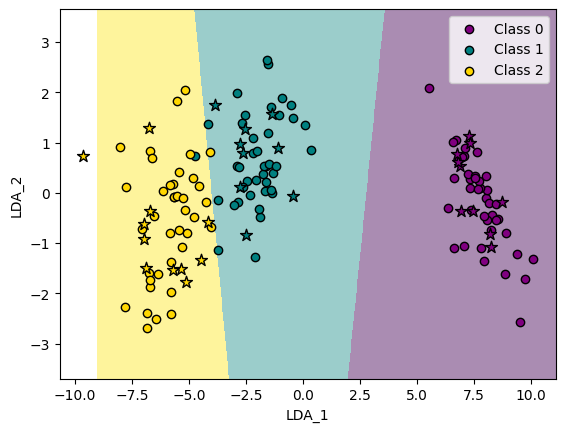

In [54]:
ContourPlot(estimator=classifier_,
            X_train=X_train_lda, y_train=y_train.values.ravel(),
            X_test=X_test_lda,   y_test=y_test.values.ravel(),
            labels=('LDA_1', 'LDA_2'))

# balls represents training dataset
# stars represents test dataset

In [ ]:
# both PCA as LDA are linear transformation techniques